In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# Koch et al. network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 7)
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.fc1 = nn.Linear(256*6*6, 4096)
        self.fc2 = nn.Linear(4096, 1)

    def forward(self, x1, x2):
        x1 = self.pool(F.relu(self.conv1(x1)))
        x1 = self.pool(F.relu(self.conv2(x1)))
        x1 = self.pool(F.relu(self.conv3(x1)))
        x1 = F.relu(self.conv4(x1))
        x1 = x1.view(-1, 256*6*6)
        x1 = torch.sigmoid(self.fc1(x1))
        
        x2 = self.pool(F.relu(self.conv1(x2)))
        x2 = self.pool(F.relu(self.conv2(x2)))
        x2 = self.pool(F.relu(self.conv3(x2)))
        x2 = F.relu(self.conv4(x2))
        x2 = x2.view(-1, 256*6*6)
        x2 = torch.sigmoid(self.fc1(x2))
        
        xfinal = torch.abs(x1 - x2)
        xfinal = self.fc2(xfinal)
        xfinal = xfinal.view(-1)
        return xfinal


In [5]:
from pokemon_loader import PokemonLoader

In [6]:
image_directory = "./kaggle-one-shot-pokemon/"

data_transforms = torchvision.transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize([105, 105]),
     transforms.ToTensor()])

train_loader = torch.utils.data.DataLoader(
    PokemonLoader(train=True, root_dir=image_directory, preload=True,
                  transform=data_transforms, n=4096),
                  batch_size=16, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    PokemonLoader(train=False, root_dir=image_directory,
                  transform=data_transforms, n=1024),
                  batch_size=16, shuffle=True)


100%|██████████| 1024/1024 [00:00<00:00, 195474.57it/s]

Generating 4096 triplets
Generating 1024 matches


In [10]:
import math
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=math.sqrt(2.0))
        nn.init.constant_(m.bias.data, 0.1)

net = Net()
net.apply(weights_init)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1, bias=True)
)


Net(
  (conv1): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1, bias=True)
)

In [15]:
critetion = torch.nn.BCEWithLogitsLoss()

def train_model(train_loader, optimizer, n_epochs=5):
    net.train(True)
    
    for epoch in range(n_epochs):
        running_loss = 0
        for idx, (img_a, img_p, img_n) in enumerate(train_loader):
            data_a, data_p, data_n = img_a.to(device), img_p.to(device), img_n.to(device)

            out_p, out_n = net(data_a, data_p), net(data_a, data_n)
        
            labels_p = torch.ones(out_p.size()[0], dtype=torch.float).to(device)
            labels_n = torch.zeros(out_n.size()[0], dtype=torch.float).to(device)
            
            crit_p = critetion(out_p, labels_p)
            crit_n = critetion(out_n, labels_n)
            loss = torch.sum(crit_p + crit_n, 0)
            print(out_p)
            print(out_n)
            print(loss.item())
            #loss = torch.sum(torch.max(dist_1 - dist_2 + torch.ones(dist_1.size()[0]).to(device), torch.zeros(dist_1.size()[0]).to(device)), 0)
            #print(loss.item())
            
            running_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if idx % 10 == 9:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.5f' %
                      (epoch + 1, idx + 1, running_loss / 10))
                running_loss = 0.0
                
        results, labels = test_model(test_loader, net)
        print(results[:10])
        are_same = [elt[0] == 1 for elt in labels]
        print(are_same[:10])
        think_same = [elt > 0 for elt in results]
        n_correct = 0
        n_total = len(think_same)
        for i in range(n_total):
            if think_same[i] == are_same[i]:
                n_correct += 1
        print(f"Accuracy: %.1f%%" % (100 * n_correct/n_total))
                
def test_model(test_loader, model):
    model.train(False)

    results, labels = [], []
    for idx, (img_1, img_2, same) in enumerate(val_loader):
        data_1, data_2 = img_1.to(device), img_2.to(device)

        out = model(data_1, data_2)

        results.extend(out.data.to('cpu').numpy())
        labels.extend(same.data.to('cpu').numpy())


    return results, labels

In [16]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
train_model(train_loader, optimizer, 1)

tensor([4.1500, 5.2301, 4.4823, 3.3329, 1.1816, 4.0412, 4.4734, 3.7868, 7.0713,
        4.7470, 3.1823, 6.0583, 4.1399, 7.5146, 4.8685, 3.9211],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([-13.0556, -13.1062,  -1.8656, -14.0770,  -3.5128,  -1.3648,  -7.0871,
         -5.5804,   1.3931,  -7.8576, -18.1793,  -6.6857,   1.0957,  -6.5266,
         -4.7372,  -3.8046], device='cuda:0', grad_fn=<ViewBackward>)
0.24502117931842804
tensor([4.2029, 1.1810, 3.4167, 2.8514, 2.4685, 3.9168, 3.4461, 3.4461, 1.1810,
        2.1675, 3.4461, 4.0878, 1.1810, 1.1810, 3.4989, 4.6123],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -4.6615,  -1.9099,  -6.7277,  -8.5917,  -9.5483,  -9.8802,  -7.7899,
         -1.3573,  -4.1843, -11.6733, -17.3343, -10.2508,  -6.3496,  -7.0198,
         -0.0886,  -4.1704], device='cuda:0', grad_fn=<ViewBackward>)
0.1622120440006256
tensor([ 1.6934,  3.6685,  5.8929, -1.6285,  3.6090,  3.2857,  3.6090, -0.1856,
         2.6608,  4.4926,  4.1215,  5.8899,

tensor([ 5.0199, 11.4998,  6.2163,  3.5140,  5.7061,  0.4956,  3.5779,  4.2133,
         4.0686,  3.4117,  3.4147,  1.0047,  6.9582,  1.8846,  7.7526, 11.4998],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -7.0486, -16.0261,  -1.1960,  -5.3489,  -4.2539,  -2.1200,  -6.8505,
         -2.3744,   0.3327,  -0.9387,   0.7888,  -8.0557,   2.4565,  -7.0511,
         -2.4773,  -1.7030], device='cuda:0', grad_fn=<ViewBackward>)
0.42111170291900635
[1,    20] loss: 0.44815
tensor([1.5329, 2.0954, 6.6335, 6.3461, 4.7367, 2.7722, 5.1097, 4.5833, 4.0144,
        4.7457, 2.8211, 2.7876, 2.0954, 5.0764, 5.1838, 1.6872],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -1.1805, -10.7831,  -5.2728,  -0.4643,  -6.8596,  -6.6842,  -5.3531,
         -3.0429,  -0.1445,  -3.7770,  -6.9626,  -4.9990,  -7.9026,   0.8593,
         -1.2459,  -4.8057], device='cuda:0', grad_fn=<ViewBackward>)
0.23648260533809662
tensor([ 3.4127,  2.8339,  2.1381,  4.1160,  2.1713, -0.8716,  3.3659,  4.7912,
 

tensor([5.0611, 3.6628, 7.7326, 3.2951, 4.0080, 7.1221, 3.2489, 6.3868, 3.8893,
        4.7416, 4.4069, 2.9609, 2.0135, 6.3868, 0.9559, 6.3858],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -7.4003,  -6.3743,  -2.5591,  -4.4009,  -2.2197, -13.2066,  -6.9724,
         -7.7787,  -4.6110,  -9.4074, -11.0585, -10.2242,  -4.5349,  -3.9851,
         -3.8541,  -3.3383], device='cuda:0', grad_fn=<ViewBackward>)
0.06007001921534538
tensor([7.9907, 5.8350, 4.1708, 3.2893, 3.2676, 3.2498, 5.2483, 4.0080, 1.8976,
        3.5785, 5.1930, 3.1553, 5.1930, 3.2498, 3.8554, 5.7043],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -4.0731,  -9.8734,  -8.1330,  -6.2964,  -5.9029,  -5.1325,  -9.7555,
         -8.3994, -10.2737,  -9.2861,  -3.6907,  -8.5737,  -4.7619,  -5.2754,
         -6.2599, -11.1403], device='cuda:0', grad_fn=<ViewBackward>)
0.03154473006725311
[1,    40] loss: 0.22817
tensor([2.8082, 5.2549, 2.3561, 5.9970, 6.0959, 7.8492, 3.6102, 8.4921, 4.0065,
        4.4205, 6

tensor([0.7682, 3.0281, 1.3601, 4.9964, 2.3646, 2.6951, 4.7251, 2.6951, 2.0889,
        3.0410, 1.1516, 1.9241, 1.9324, 3.9015, 3.6478, 3.4027],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([-10.3677,  -5.1814,  -6.8441,  -7.3813,  -3.6163,   0.0424,  -7.2806,
         -7.7126, -12.5767,  -0.8680,  -1.9575,   1.8665,  -1.9080,   2.2242,
          0.8255,  -2.7362], device='cuda:0', grad_fn=<ViewBackward>)
0.5400165319442749
tensor([ 2.8266, -0.3375,  5.1713,  0.2033,  3.0826,  2.9563,  3.8867,  2.9163,
         1.9984, -2.7760,  2.8975,  3.4371,  3.2055,  4.8476, -2.9024,  4.3774],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -3.0355,  -3.0085, -11.1926,  -0.5151,  -4.1853,  -0.9669,  -3.7398,
         -9.1114,  -1.6750,  -3.5992,   2.8859,  -2.5803,  -3.1346,  -5.0274,
        -10.4066,   5.0414], device='cuda:0', grad_fn=<ViewBackward>)
1.0626599788665771
tensor([ 2.9499,  1.0970,  2.9927,  4.1336,  4.0687,  3.8888,  3.8351,  3.5340,
         4.1619,  4.3444,  4

tensor([ 2.7740,  2.4816,  4.5773,  5.5713,  2.9841, -0.3088,  2.7628,  4.5169,
         3.1637,  2.5420,  5.5713,  3.1194,  4.7728,  4.5887,  3.8291,  2.1935],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -2.4988,  -7.3607,   0.6941,  -5.9063,  -7.1785,  -0.1003,  -2.1757,
         -6.9186,  -3.2034,  -6.6574,  -0.8718,  -6.0950, -10.3381,  -3.2646,
         -5.4574,  -2.7021], device='cuda:0', grad_fn=<ViewBackward>)
0.24251441657543182
tensor([4.7204, 2.6404, 2.8777, 1.7147, 4.7345, 5.0261, 3.0800, 1.4532, 3.7399,
        1.3477, 2.9774, 1.7147, 3.3502, 4.6808, 4.6808, 4.4225],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -6.9618,  -3.3693,  -6.7649,  -7.6271, -10.4932,  -9.5591,   1.7288,
         -8.0258,  -8.4050,  -1.9129,  -5.2891,  -8.5259,  -8.0980,  -1.3562,
         -3.4781,   1.7747], device='cuda:0', grad_fn=<ViewBackward>)
0.3353949189186096
tensor([ 2.7464,  6.1104,  1.5292,  2.4835,  3.9781,  4.1749,  1.6505,  2.4835,
         4.1749,  2.0832,  

tensor([4.9906, 6.3493, 6.0565, 4.3291, 4.7461, 6.5651, 5.2684, 5.0049, 5.0049,
        5.7864, 3.1487, 3.2611, 6.8648, 7.3088, 4.5139, 5.8590],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([  1.3763,  -6.7776,  -8.1885,  -7.8897,  -6.9967,  -9.7228,  -6.3998,
         -3.2370,  -8.1225,  -4.1870,  -9.7923, -12.1806,  -0.0158, -10.6217,
         -7.6658,  -9.6978], device='cuda:0', grad_fn=<ViewBackward>)
0.15601947903633118
tensor([4.4034, 5.7138, 4.4034, 4.9484, 1.5964, 5.3255, 5.8260, 3.8002, 4.6934,
        3.9997, 3.8544, 5.3255, 5.4768, 7.2666, 6.4649, 3.3315],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -3.9825,  -8.1806,  -7.5042, -11.4229, -15.0156,  -4.1502,  -8.1114,
        -10.7851,  -9.8861,  -8.8974, -14.4256,  -3.1179, -11.7935,  -1.3798,
        -17.9332,  -6.1810], device='cuda:0', grad_fn=<ViewBackward>)
0.0405643954873085
tensor([3.3884, 3.6920, 7.2035, 4.2236, 6.1215, 6.1330, 3.3884, 4.4404, 5.5156,
        2.3656, 6.5931, 4.0838, 7.4462, 2.3

tensor([1.3337, 3.4496, 3.5211, 2.0200, 1.9575, 5.7124, 9.1590, 3.4311, 3.4496,
        1.0100, 2.4882, 4.6761, 4.1458, 1.5183, 2.9476, 3.2823],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([-12.0366,  -2.9669,  -2.0598,  -2.9627,  -7.2905,  -5.0098,  -6.1453,
         -9.2184,  -4.4228, -12.2807,  -3.3738,  -7.1161,  -2.1750,  -9.1931,
        -10.0048,  -7.2322], device='cuda:0', grad_fn=<ViewBackward>)
0.10649675130844116
tensor([ 2.9301,  3.3492,  3.1802,  3.6226,  4.4597,  2.6490,  2.4503,  4.0191,
         6.3478,  3.0128,  2.6112,  5.0157, -2.4856,  5.5626,  3.2420,  5.0701],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([-10.8731,  -8.3218,  -9.6159,  -8.5545,  -7.4472, -12.8145,  -5.1045,
         -1.2895, -11.8481, -18.0353,  -3.1930,  -7.7775, -11.4989, -11.8400,
        -12.8968,  -1.0491], device='cuda:0', grad_fn=<ViewBackward>)
0.22916549444198608
tensor([ 1.7351,  0.1574,  1.4633,  3.1275,  1.8656, 10.9698,  5.1909,  3.2817,
         2.5624,  2.2688, 

tensor([0.9020, 3.0233, 5.6236, 7.1382, 3.0033, 5.1371, 3.1836, 6.2480, 3.5976,
        5.3155, 3.5144, 5.5524, 3.1616, 6.0636, 4.1755, 4.3072],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -5.8087, -11.6822,  -9.6082, -15.7113,  -3.9313, -14.8535,  -7.4602,
        -13.0374, -11.8481, -12.9013,  -9.3666,  -6.8161, -10.6952, -10.8297,
         -9.5924, -14.4503], device='cuda:0', grad_fn=<ViewBackward>)
0.04070195183157921
tensor([5.2887, 3.7604, 6.8868, 0.6102, 3.5000, 0.7321, 4.5711, 3.4139, 5.2887,
        3.5659, 2.6936, 2.8278, 2.6250, 7.3671, 4.3295, 5.3419],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([-17.8955,  -1.6358,  -5.9790, -10.6448,  -8.9127,  -6.3253,  -9.7141,
        -13.8845, -13.6011,  -8.2184,  -8.3099, -11.7284, -12.9654,  -6.2938,
         -8.2094,  -6.8608], device='cuda:0', grad_fn=<ViewBackward>)
0.08490558713674545
tensor([5.1997, 3.1899, 3.4526, 4.6866, 2.3506, 4.4835, 1.7550, 1.2337, 4.0324,
        3.8102, 2.5863, 2.2028, 7.2117, 2.

tensor([5.7144, 3.7780, 5.7266, 6.0240, 4.5497, 7.4315, 7.2353, 3.0476, 3.8969,
        3.5672, 8.1274, 6.5014, 7.1855, 3.9894, 6.6799, 5.7144],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([-20.3338,   1.3098,   1.3798,  -8.5610,  -7.9560,  -4.1490,  -7.5588,
        -17.4762,  -6.3890,  -6.6914,  -2.3329, -22.0841,  -8.5670, -18.4879,
          1.1700, -10.1324], device='cuda:0', grad_fn=<ViewBackward>)
0.30430901050567627
tensor([4.5457, 3.6011, 4.0699, 6.2587, 3.6171, 6.6524, 3.8742, 3.9863, 4.3597,
        3.7428, 4.5803, 3.9880, 6.8037, 2.1067, 3.1208, 5.6216],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -5.2593, -10.7918, -12.6241,   2.0524,  -9.2876,  -3.3704, -10.0425,
         -7.6635, -17.0210,   4.6304,  -4.7626, -15.7814,  -7.4956, -12.9054,
         -7.0261, -16.4816], device='cuda:0', grad_fn=<ViewBackward>)
0.45083150267601013
tensor([-2.9114,  2.6646,  2.7620,  4.8731,  7.1536,  3.6696,  6.2719,  2.7075,
         2.7075,  2.4987,  3.7750,  7.0242

tensor([4.1589, 7.3901, 4.4869, 3.3859, 6.0293, 4.9908, 4.4471, 3.0195, 4.9908,
        7.1056, 4.4943, 4.8414, 5.0481, 4.5473, 6.3737, 3.8065],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -9.9332,  -6.4279,  -3.5874,  -4.2875,  -5.5905,  -3.8712,  -9.1185,
        -12.9054, -16.2591, -15.6365, -12.7677,  -5.5493,  -6.5037, -13.2932,
        -12.1450, -16.6771], device='cuda:0', grad_fn=<ViewBackward>)
0.01679684780538082
tensor([3.9516, 5.8757, 3.4650, 8.7505, 6.8887, 7.3028, 6.1521, 4.0071, 2.0644,
        5.5715, 4.0918, 5.0697, 8.1896, 4.3389, 7.6746, 6.6946],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -8.2767, -16.4250,  -8.0337,  -9.0578,  -8.4898, -12.5408,  -4.4326,
         -7.5717,  -8.9534,   3.4960, -18.7726, -14.4053,  -5.2155, -12.6051,
        -12.6817,  -4.7918], device='cuda:0', grad_fn=<ViewBackward>)
0.2367895543575287
tensor([9.0618, 3.4907, 8.0676, 4.1283, 0.0195, 7.6773, 6.4174, 6.4985, 4.5895,
        3.9707, 6.4985, 0.0195, 7.6773, 2.3

tensor([6.2560, 9.5911, 7.3298, 3.9755, 4.9279, 3.4575, 6.7807, 7.0167, 4.0316,
        7.0396, 2.3715, 6.8310, 6.6696, 6.4758, 4.4548, 4.6926],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -0.7693,  -0.6530, -20.9956,  -6.3219, -16.2851,  -6.0317, -15.1159,
         -7.0652,  -6.5453,  -3.1275, -14.3096,  -2.0979, -17.4140,  -6.1287,
         -4.9947, -11.5847], device='cuda:0', grad_fn=<ViewBackward>)
0.07297492772340775
tensor([7.4150, 7.7293, 3.4065, 4.9250, 5.6858, 7.4150, 5.1672, 6.5430, 5.0238,
        4.1732, 1.4957, 3.9577, 7.0567, 5.3391, 4.4549, 3.4527],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -2.3126,   3.1669,   2.1936, -22.1252, -10.4022,  -9.7991,  -4.3176,
        -12.2189,  -3.9490,  -9.4081, -10.7245, -14.3783,  -1.6023,  -2.9939,
         -5.0090, -10.1128], device='cuda:0', grad_fn=<ViewBackward>)
0.38855570554733276
tensor([3.5015, 1.3429, 3.7017, 6.3561, 3.5493, 2.0931, 2.7768, 5.3778, 3.1259,
        3.4260, 4.5124, 1.4634, 4.5783, 4.

tensor([ 3.3283,  5.6425,  4.0465,  2.9994,  4.4196,  6.8581, 12.7592,  7.4351,
         0.9064,  2.9499,  8.3622,  3.5644,  2.7277,  3.0764,  4.6483,  4.4057],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -5.3122,   0.0332,  -9.8263, -21.4985, -16.2802, -18.9204, -15.5704,
        -11.6396,  -6.9665,  -4.4074, -19.4025,  -6.8127,  -3.1452, -11.5530,
         -5.7855, -24.0363], device='cuda:0', grad_fn=<ViewBackward>)
0.09007146954536438
[1,   210] loss: 0.08486
tensor([4.8785, 7.2754, 5.3404, 3.2660, 2.1717, 5.2811, 4.2508, 2.1190, 7.2754,
        5.2478, 4.9030, 2.9496, 8.8616, 1.4534, 2.6738, 5.2257],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -3.8916, -10.9714, -12.5988, -16.0576, -12.0356, -17.9457,  -8.8939,
        -18.5355,  -1.7271, -15.0607, -21.1059,  -3.6717, -19.9443,  -2.3186,
        -13.0480, -20.6943], device='cuda:0', grad_fn=<ViewBackward>)
0.058801040053367615
tensor([4.6624, 2.8574, 2.7303, 1.7353, 3.3817, 1.8080, 3.2446, 4.9123, 4.5473,


tensor([4.5456, 6.2120, 3.7725, 9.6816, 1.2020, 4.7295, 9.3423, 6.0006, 3.9896,
        3.2952, 3.2952, 1.2020, 8.5013, 3.9963, 6.3487, 5.6961],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([-13.5066, -15.4487,  -6.1955,  -7.8239,  -8.0621,  -6.1940, -12.4979,
        -21.0555,  -1.6775, -10.8850,  -9.0446, -19.7897,  -8.7474, -15.7933,
         -1.5334,  -3.3918], device='cuda:0', grad_fn=<ViewBackward>)
0.06824254989624023
tensor([5.2618, 9.6581, 4.6983, 8.6070, 8.3216, 5.5905, 6.2033, 5.8456, 1.9761,
        3.2497, 6.7673, 2.4435, 4.4496, 5.4376, 5.5905, 7.0038],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -2.0920, -22.0422,  -7.8253,  -7.7890, -10.1267,  -8.3886, -16.2309,
        -13.9008,  -7.2550,  -9.0600,  -6.5149, -15.2765,  -6.5856,  -3.3065,
        -18.0658, -15.8721], device='cuda:0', grad_fn=<ViewBackward>)
0.0283372700214386
[1,   230] loss: 0.13499
tensor([5.3885, 5.0515, 0.1804, 4.9669, 2.2825, 6.3644, 4.7154, 5.6082, 5.6951,
        6.6033, 6.

tensor([7.7825, 4.8019, 6.2134, 4.3335, 7.1560, 5.2713, 9.2197, 8.0313, 4.4888,
        8.7573, 6.0152, 6.0407, 4.5860, 3.2331, 4.6888, 5.9492],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([-24.0874, -15.2046, -25.0911,  -8.6283,  -9.2880,  -8.0507, -18.3920,
         -6.8085, -13.2036,  -4.5521, -18.7017, -10.4788, -11.2676,  -2.4245,
         -4.1220, -13.0072], device='cuda:0', grad_fn=<ViewBackward>)
0.0137386629357934
tensor([ 5.7011,  5.4973, 11.8051,  8.4858,  6.2552,  6.3040,  3.4819,  4.0616,
         4.2441, 11.0118,  7.5130,  5.0144,  5.4973,  4.0953,  4.0616,  0.0285],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([ -7.9172, -19.0900,  -6.2623, -15.3339, -18.1402, -13.3312, -10.2867,
        -14.9284,  -5.6066, -19.0869, -15.1685,  -2.9663,  -6.0702, -11.3875,
        -14.8817,  -6.8047], device='cuda:0', grad_fn=<ViewBackward>)
0.053529638797044754
tensor([ 5.3373e+00, -4.4662e-03,  4.9761e+00,  6.9371e+00,  3.6477e+00,
         6.7119e+00,  1.0678e+01,

KeyboardInterrupt: 

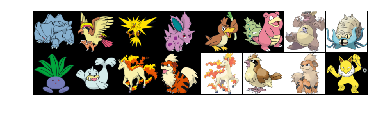

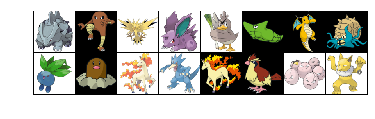

tensor([  1.5637,  -3.9720,  -0.4021,  -0.2125,  -6.7641,  -6.1137,  -8.5185,
         -7.5797,  -0.5936,  -4.7516,  -7.7639, -19.9406,  -7.7639,   2.1638,
        -11.1748,  -0.8120], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1]])


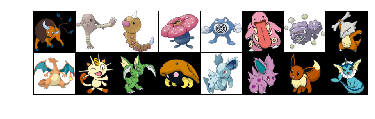

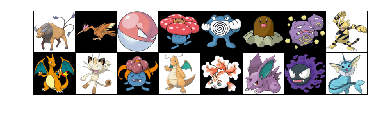

tensor([ -0.6447, -13.9441,  -5.5531,  -0.6725,   0.0917,  -8.3607,  -5.5102,
         -8.7648,  -2.4486, -12.1397, -10.6766, -15.6771, -16.0748,  -0.2125,
        -10.8700,  -2.3599], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1]])


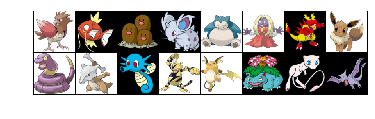

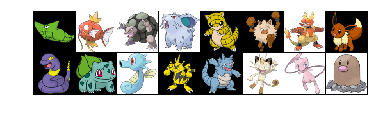

tensor([ -0.7723,  -2.3389, -10.2519,  -0.1354, -10.3218,  -0.6436,  -0.5749,
         -1.9840,  -1.7880, -13.9759,  -1.0724,  -1.5507, -10.8623, -12.6063,
         -2.1171,  -5.8283], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0]])


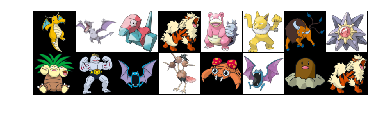

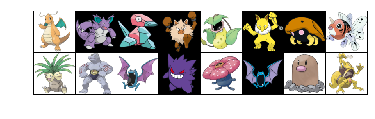

tensor([ -1.9830,   2.0317,  -9.1782,  -1.3684,  -5.3588,  -0.8120, -14.2801,
         -2.3923, -11.1426,  -4.9525,   2.0020,  -7.9866,  -0.0757,   2.0020,
         -8.5789,  -6.4512], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0]])


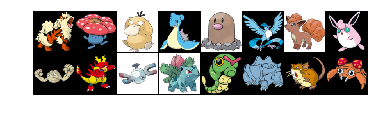

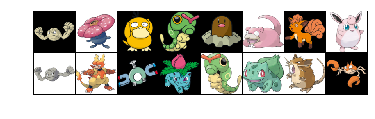

tensor([ -6.0949,  -0.6725,  -2.3538,  -2.9355,  -8.5789,  -8.1212,  -4.8565,
          0.4297,  -0.9298,  -0.5749,  -3.0672,   0.2012,  -0.7348, -10.2687,
         -3.8795, -13.8093], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0]])


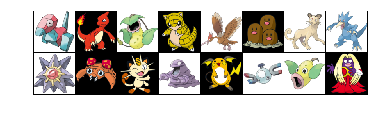

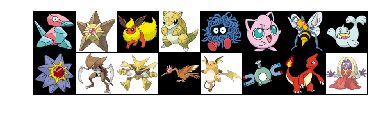

tensor([ -9.1782,  -5.7522, -10.5352,  -4.3560, -16.7920,  -6.0580, -12.7791,
        -13.6578,  -1.2715,  -4.5454,  -7.5886, -14.3854,  -8.8351,  -3.0672,
         -5.4509,  -0.3447], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1]])


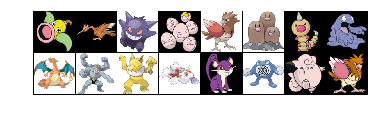

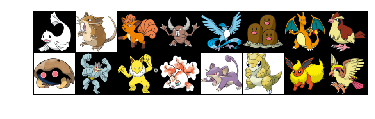

tensor([ -9.2969,  -4.5542, -15.1522,  -8.9123, -12.1615,  -4.9679,  -1.3877,
        -17.0232, -11.4805,   2.7650,  -0.8120,  -5.0732,  -2.3148, -14.6374,
         -9.1237, -10.5565], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0]])


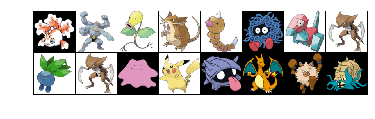

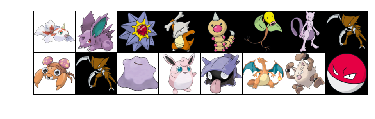

tensor([ -5.0732,  -4.6764, -22.0533,  -6.4140,  -1.3023, -18.5067,  -6.2608,
          2.0254, -18.4973,   2.0254, -12.0782, -13.4867,   1.6683,  -2.4486,
         -5.5026,  -0.8961], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0]])


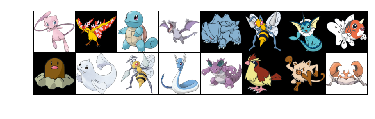

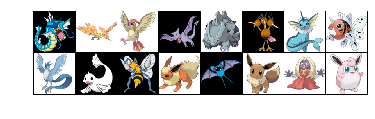

tensor([-10.9606,   1.1247, -12.9325,  -2.7403,   1.5637,  -6.0776,  -2.3599,
          0.0561, -16.8841,  -7.9035,  -3.1850, -15.2835,   3.0139,  -2.8973,
         -3.7919,  -8.3424], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]])


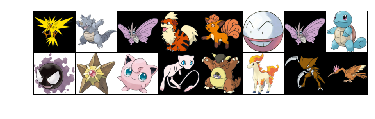

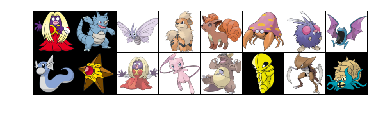

tensor([ -0.8456,   1.4265,  -4.9951,  -5.0967,  -4.8565,  -9.7053,  -5.9061,
         -9.4811,  -4.4776,  -1.4471, -11.2030,  -2.1171,  -5.1228,  -4.9045,
          2.0254,  -7.3178], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0]])


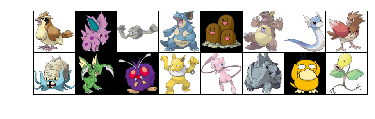

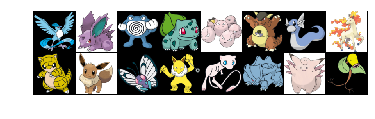

tensor([-14.3803,  -0.2125,  -1.5315,  -8.4811, -12.4991,  -5.1228,  -2.3252,
         -8.4252,  -9.4542, -11.3073,  -7.2412,  -0.8120,  -2.1171,   1.5637,
         -8.2748,  -8.3250], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1]])


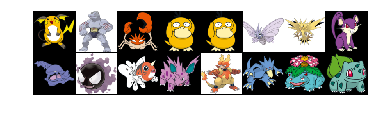

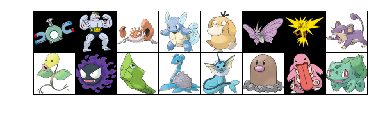

tensor([-10.8809,  -4.9525,  -8.9957, -11.6670,  -2.3538,  -4.9951,  -0.4021,
         -2.3148,   0.1529,  -1.1245,  -2.9616,  -6.7205, -16.5804,  -2.7551,
        -26.2251,  -3.4351], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1]])


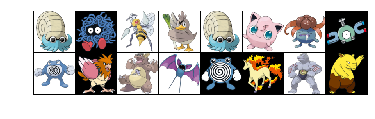

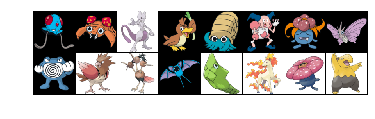

tensor([-10.4311, -26.4787, -11.5098,  -6.7641,  -2.3565,  -3.8357,  -2.6004,
        -10.0933,   0.0917,  -5.7491,  -7.5696,   3.8062, -10.4346,  -7.7639,
         -6.6110, -10.7342], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1]])


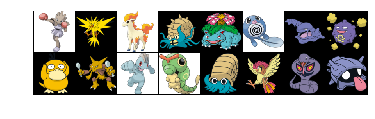

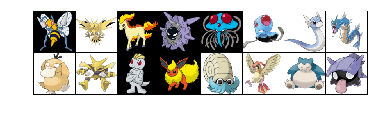

tensor([-20.4617,  -0.4021,  -0.9636,  -9.5018,  -4.8025,  -6.5478,   1.1876,
        -11.3561,  -2.3538,  -4.3295,  -3.3738, -11.2977,  -2.3565,  -2.7778,
         -7.6478,   1.6683], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1]])


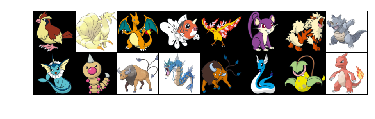

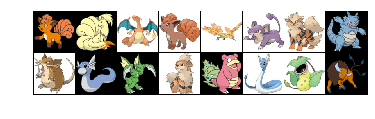

tensor([ -2.0761,  -2.2674,  -2.4486,  -0.2625,   1.1247,  -2.3148,  -3.9772,
          1.4265, -10.5468, -15.2285, -15.0702, -10.2205,  -3.8563,   0.2504,
          3.0319,  -2.8758], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0]])


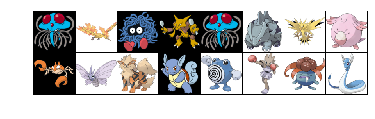

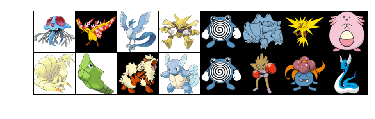

tensor([ -1.1455,   1.1247, -17.2549,  -4.3295,  -9.7230,   1.5637,  -0.4021,
         -2.1360,  -8.2499, -14.0824,  -3.9772,  -6.2375,   0.2541, -11.8736,
         -2.6004,   0.2504], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]])


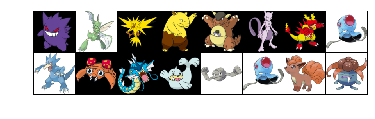

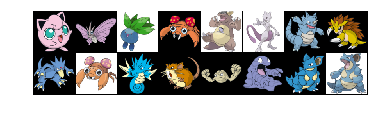

tensor([-12.9248,   0.7160, -19.5020, -12.1887,  -5.1228,   1.1545, -12.5985,
        -19.4042,  -8.0495,  -8.4874,  -5.9717,  -8.5305,  -0.9298,  -3.1193,
        -12.0011, -10.9089], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0]])


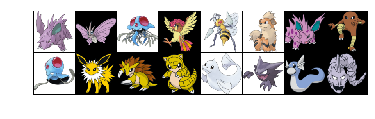

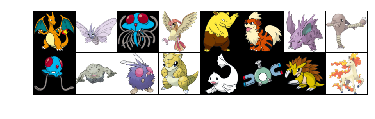

tensor([-13.4613,  -4.9951,  -1.1455,  -2.7778,  -5.0473,  -5.0967,   0.4704,
        -11.1667,   5.2390, -12.9308, -15.7449,  -4.3560,  -7.9035,  -2.9086,
        -16.0085,  -4.3512], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0]])


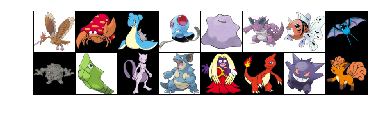

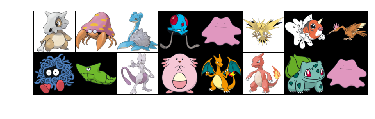

tensor([ -7.3282,  -1.7213,  -4.5450,   5.2390, -12.0782, -14.3527,   0.0561,
        -17.9848, -11.5977,   0.8706,   1.1545, -11.8842,  -2.5757,  -1.7532,
         -5.5255,  -4.5382], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0]])


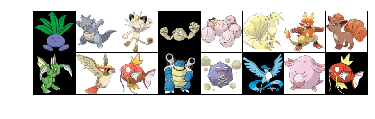

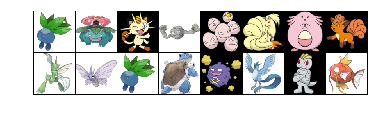

tensor([ -0.5936, -13.4649, -12.1397,  -0.9298,  -1.6733,  -2.2674, -12.1935,
         -4.8565,   1.2371, -11.2718, -17.3289,  -4.7785,  -4.0022,   1.1532,
         -2.0300,  -2.3389], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1]])


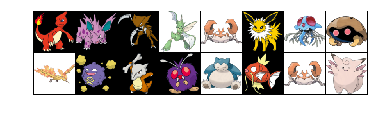

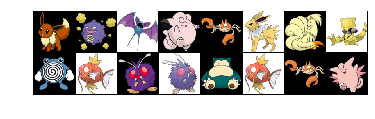

tensor([ -2.0829, -14.2878,  -8.3229,  -3.0231, -12.3330,  -9.0646, -21.0342,
        -10.9224, -13.1802, -12.5975, -11.0112,  -4.0706,  -7.3660,  -2.3389,
        -12.3330,  -3.8959], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]])


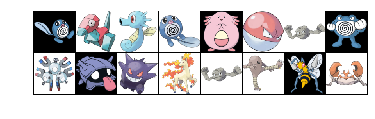

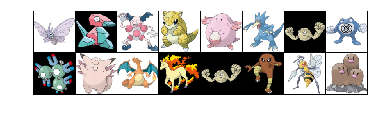

tensor([  1.8536,  -9.1782,  -9.7736, -14.7383,  -2.1360, -13.5593,  -0.9298,
          0.0917,  -0.3307,  -2.9664, -12.5086,  -7.7639,  -0.9298, -11.1667,
         -3.1850, -10.3423], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0]])


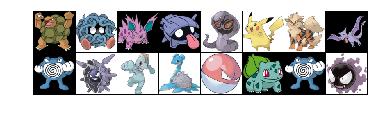

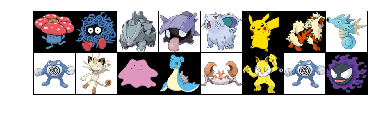

tensor([-12.0500,  -6.0916,  -6.6088,   1.6683, -11.0556,  -2.9559,  -3.9772,
         -4.6434,   0.0917,  -8.0707, -13.0780,  -4.5450,  -1.2441, -18.8311,
          0.0917,  -1.1245], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1]])


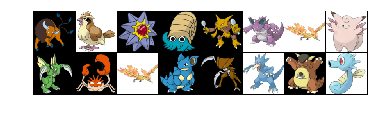

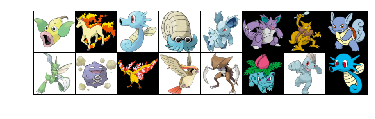

tensor([ -1.8959, -17.2221, -10.4448,  -2.3565, -13.9610,   1.7366,  -4.2244,
         -6.4494,   1.2371, -11.6440,   1.1247, -10.4680,   2.0254,  -6.0491,
        -17.1123,  -1.0724], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1]])


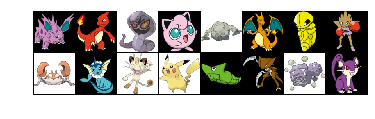

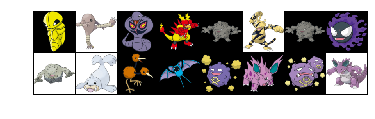

tensor([ -9.9466, -13.8859,   1.3916,  -6.8489,   2.4760,  -6.6050, -11.8887,
        -10.2850, -10.0539,  -3.8093,  -9.3885, -10.0368, -19.1398,  -7.2202,
         -5.5102,  -3.1612], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0]])


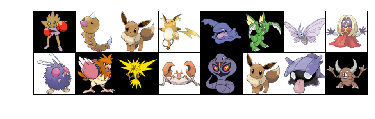

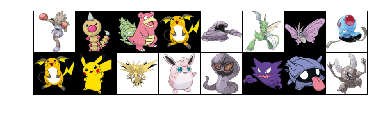

tensor([-11.8736,  -1.3023,  -5.8169,  -8.8351,  -0.2488,   1.2371,  -4.9951,
        -23.6450, -17.7524, -13.1579,  -0.4021,  -8.3424,   1.3916, -15.1173,
          1.6683,  -2.3652], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1]])


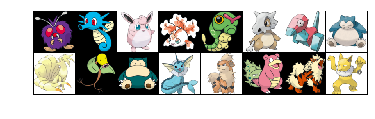

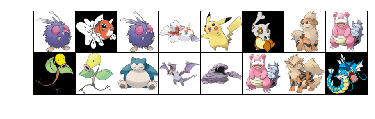

tensor([ -4.0706, -13.7685,  -7.6666,  -5.0732,  -7.9937,   0.2628,  -9.1483,
         -7.2508,  -9.5819,  -8.3250,  -7.3660,  -4.2723, -14.2488,  -2.1725,
         -3.9772, -10.0428], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0]])


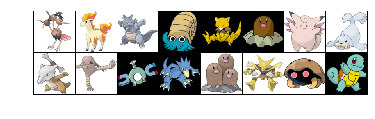

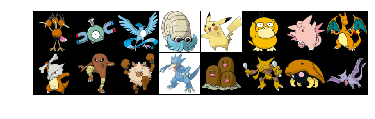

tensor([ -2.7951, -11.0641,   1.0610,  -2.3565,  -1.9188, -14.4405,  -3.8959,
        -15.1548,  -2.3502, -11.1667, -14.6995,  -8.0495,  -4.9679,  -4.3295,
        -11.4976,  -8.6452], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0]])


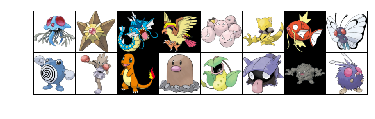

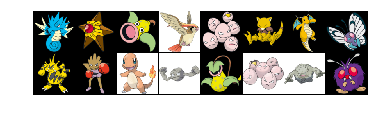

tensor([ -5.4545,  -1.4471, -12.6629,  -5.2175,  -1.6733,  -3.0475,  -7.8141,
         -5.6702, -18.3355, -11.8736,  -5.5895,  -8.9597,   3.0319, -11.5754,
          2.4760,  -4.0706], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1]])


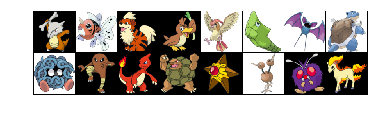

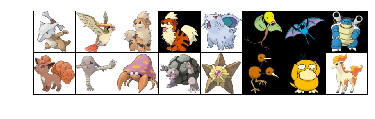

tensor([ -2.3502,  -8.0381,  -5.0967,   0.1012, -12.3108, -17.5946,   3.8062,
         -4.7785, -13.1237, -11.1667,  -4.4684, -11.8025,  -1.4471,  -6.0693,
        -12.3363,  -0.9636], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1]])


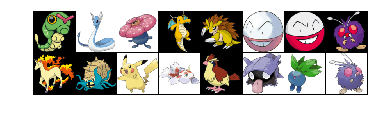

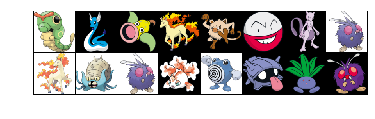

tensor([ -0.7348,   0.2504,  -5.9670, -14.9980,  -2.9738,  -7.0331, -11.5904,
         -4.0706,  -7.7639,  -7.5797, -15.3603,  -5.0732, -16.5725,   1.6683,
         -0.5936,  -4.0706], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1]])


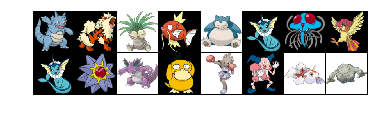

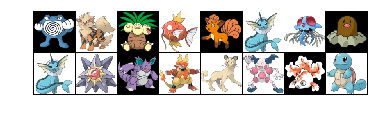

tensor([ -1.1703,  -3.9772, -11.1426,  -2.3389,  -9.7952,  -2.3599,  -1.1455,
        -12.1048,  -2.3599,  -1.2715,   1.7366,  -6.6641, -20.0014,   0.7640,
         -5.0732,  -9.6475], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0]])


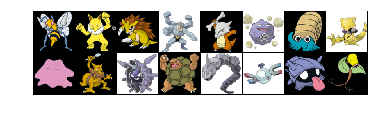

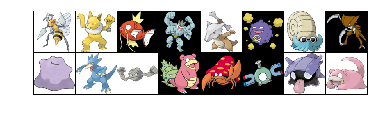

tensor([ -3.1850,  -0.8120,  -8.7528,   2.7650,  -2.3502,  -4.0022,  -2.3565,
         -9.5322, -12.0782, -18.4775,  -6.9526, -12.4266, -13.1299,  -3.0672,
          1.6683, -14.5011], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0]])


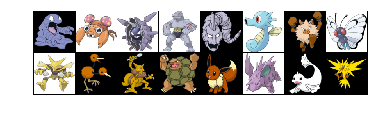

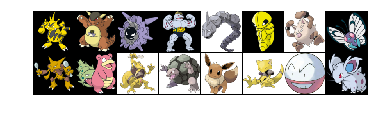

tensor([-15.9080,  -6.1176,   0.7813,  -4.9525,   1.2361, -12.5015,  -5.5026,
         -5.6702,  -4.3295,  -5.4986,  -3.4180, -11.8025,  -1.9840, -11.1926,
         -4.7437, -16.8256], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0]])


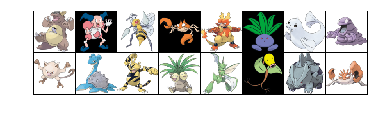

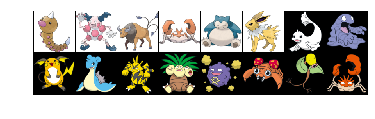

tensor([ -9.2900,   0.7640,  -9.8607, -12.3330, -10.3752, -10.4681,  -7.9035,
         -0.8467, -12.0544,  -4.5450,  -1.5507, -11.1426,  -9.3330, -11.4275,
         -7.5847,  -8.9957], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1]])


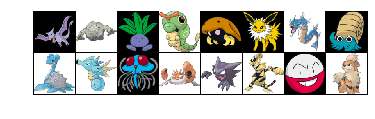

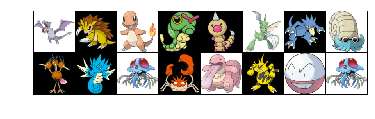

tensor([ -2.7403, -14.5642,  -6.1086,  -0.7348, -10.2955, -11.6593,  -5.4530,
         -2.3565, -13.9030,   0.6960,  -1.1455,  -8.9957,  -8.3241,  -1.5507,
         -7.0331, -16.4558], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0]])


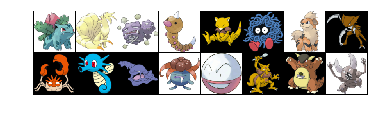

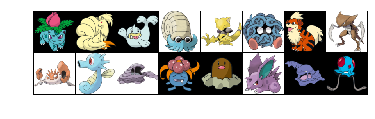

tensor([  0.2012,  -2.2674,  -9.7673,  -7.5932,  -3.0475,  -6.0916,  -5.0967,
          2.0254,  -8.9957,  -1.0724,  -0.2488,  -2.6004, -16.5680, -15.2785,
        -13.6148, -13.4468], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]])


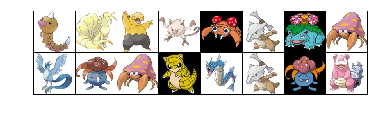

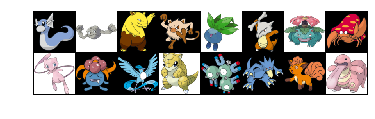

tensor([ -5.2865,  -9.3674, -10.7342,  -9.4494, -10.8917,  -2.3502,   0.9741,
         -1.7213,  -8.9154,  -2.6004,  -9.7479,  -4.3560,  -8.3128,  -3.1158,
        -16.2404, -10.3495], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]])


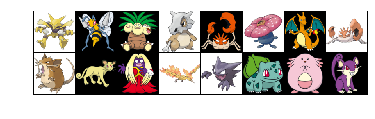

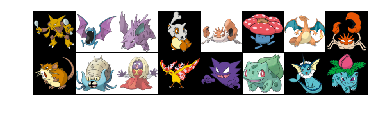

tensor([ -4.3295, -15.9660, -15.0467,   0.2628,  -8.9957,  -0.6725,  -2.4486,
         -8.9957,  -3.8795,  -8.3678,  -0.3447,   1.1247,   0.4632,  -3.4351,
        -10.6343, -10.6353], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0]])


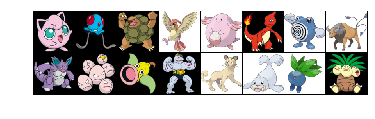

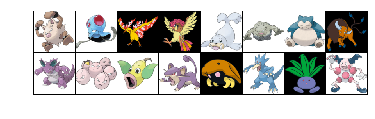

tensor([ -4.4638,   5.2390,  -9.9778,  -2.7778,  -8.2008, -11.2855, -11.7432,
         -0.6447,   1.7366,  -1.6733,  -5.8603,  -2.9179, -14.1734,  -4.5457,
         -0.5936,  -5.4441], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0]])


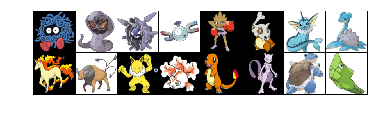

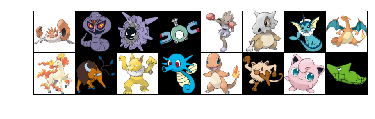

tensor([-22.4112,   1.3916,   0.7813,  -3.0672, -11.8736,   0.2628,  -2.3599,
        -16.0107,  -7.7639,  -0.6447,  -0.8120, -14.7209,  -5.5895, -11.0417,
         -8.8155,   0.8706], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1]])


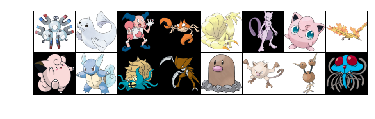

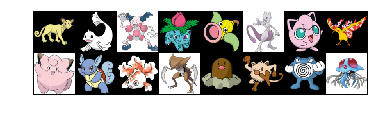

tensor([-19.8624,  -7.9035,   0.7640, -18.8145,  -7.7132,   1.1545,  -4.0885,
          1.1247,   3.8554,  -6.2375,  -4.2241,   2.0254,  -8.5789,  -9.4494,
        -11.1797,  -1.1455], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1]])


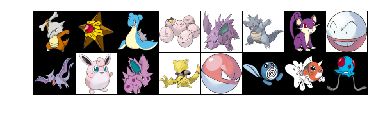

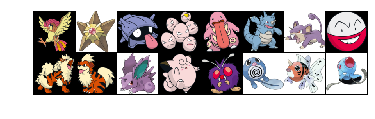

tensor([ -7.2390,  -1.4471,  -3.0778,  -1.6733, -15.4044,   1.4265,  -2.3148,
         -7.0331,  -9.7091, -14.9668,  -0.2125,  -6.4273,  -2.1266,  -0.1856,
          0.0561,   5.2390], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1]])


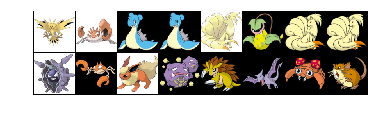

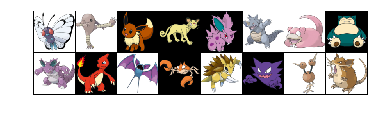

tensor([-11.5641, -14.0303,  -9.0059, -12.0238,   1.1429, -11.0403,  -4.3466,
         -9.8859,  -5.8952,  -4.2136, -15.3203, -18.2020, -10.2543,  -8.7265,
         -8.7212,  -3.8795], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1]])


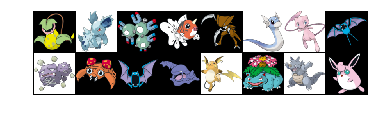

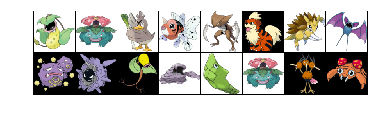

tensor([  3.0319,  -9.2833, -15.1034,   0.0561,   2.0254, -17.0063,  -9.8762,
          3.8062,  -5.5102,  -6.9599, -10.8704,  -0.2488,  -5.8528,   0.9741,
         -9.7901,  -3.9273], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0]])


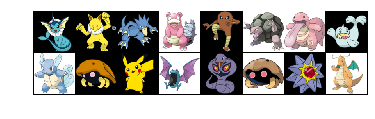

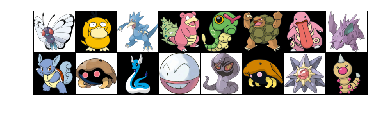

tensor([ -5.7594,  -2.7830,  -8.0495,  -2.1725, -10.7558, -11.8025, -11.2297,
         -9.1956,  -6.2375, -11.4976, -16.6072,  -8.8065,   1.3916, -11.4976,
         -1.2715,  -1.8817], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0]])


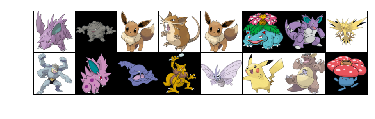

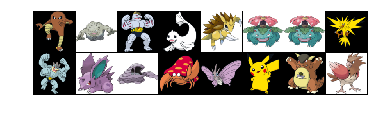

tensor([-11.1920,   2.4760,  -4.3487,  -9.0437, -11.4635,   0.9741, -10.5254,
         -0.4021,   2.7650,  -0.2125,  -0.2488,  -5.3536,  -4.9951,  -2.9559,
         -5.1228,  -7.4912], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0]])


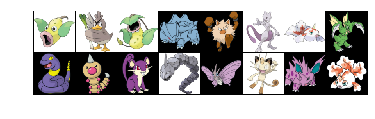

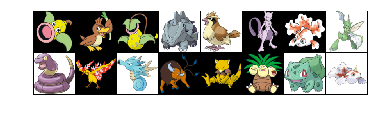

tensor([ -5.8603,  -6.7641,   3.0319,   1.5637,  -2.7501,   1.1545,  -5.0732,
          1.2371,  -1.7880,   2.1068,  -8.7329, -14.9124,  -9.3603, -12.1605,
        -11.0081,  -5.0732], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1]])


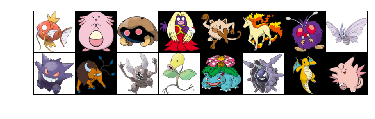

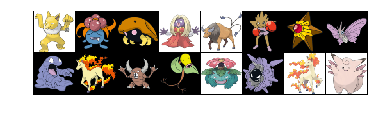

tensor([-13.7683, -21.3550, -11.4976,  -0.3447,   0.6033,  -3.2849,  -8.2837,
         -4.9951,  -6.0406, -17.1932,  -2.3652,  -8.3250,   0.9741,   0.7813,
        -13.3100,  -3.8959], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1]])


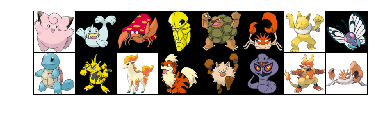

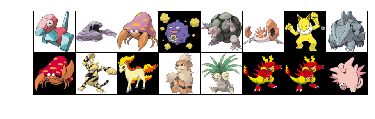

tensor([ -9.4327, -10.2500,  -1.7213, -14.9217, -11.8025,  -8.9957,  -0.8120,
         -9.6791,  -8.8545,  -1.5507,  -0.9636,  -5.0967,  -7.8381, -10.7095,
         -0.5749,  -5.4056], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0]])


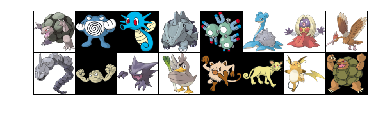

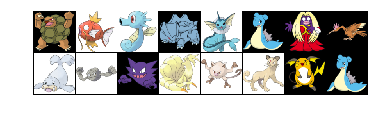

tensor([-11.8025, -13.8210,  -1.0724,   1.5637,  -5.2294,  -4.5450,  -0.3447,
         -4.7020,  -1.8179,  -0.9298,   0.4632, -11.5472,  -9.4494,  -5.8269,
         -8.8351,  -4.2590], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0]])


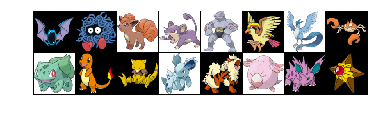

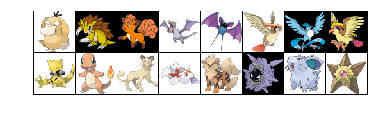

tensor([-11.3412, -11.9759,  -4.8565,  -7.6798,  -5.9933,  -5.2175,   1.1532,
         -1.4788, -13.0709,  -5.5895,  -9.4471, -13.3517,  -3.9772,  -6.1421,
         -7.9829,  -1.4471], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1]])


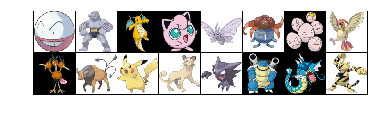

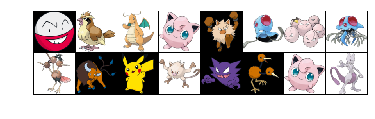

tensor([ -7.0331, -10.0694,  -1.9830,  -4.0885, -14.9396, -10.9398,  -1.6733,
        -18.9390,  -2.7951,  -0.6447,  -2.9559,  -8.9612,   0.4632,  -8.4214,
         -7.5323, -10.1989], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0]])


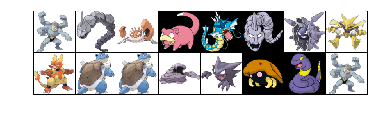

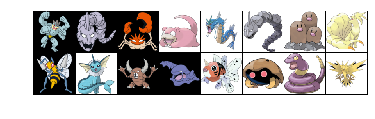

tensor([  2.7650,   1.2361,  -8.9957,  -2.5322,  -5.3312,   1.2361, -12.7171,
         -3.7084,  -6.3809, -11.7697,  -3.4267,  -0.2488, -11.0772, -11.4976,
         -1.7880, -13.9073], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0]])


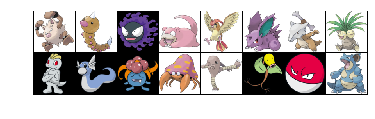

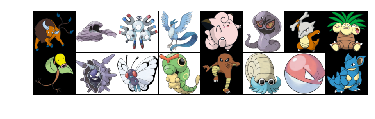

tensor([-12.3121,  -8.1063,  -6.6421, -13.1594,  -5.4992, -10.6474,  -2.3502,
        -11.1426,  -4.2553,  -1.8506,  -5.8797,  -7.0212, -11.1667, -10.3117,
          0.3310,  -1.1623], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1]])


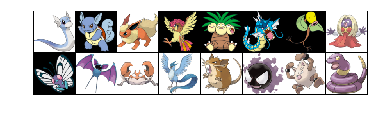

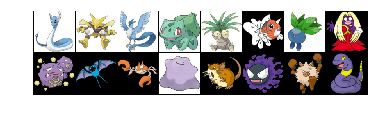

tensor([ -1.3874,  -7.0226, -16.8647, -17.9592, -11.1426, -10.5408,  -5.7944,
         -0.3447, -10.2984,   3.8062, -12.3330,  -1.3018,  -3.8795,  -1.1245,
         -5.5026,  -1.7880], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]])


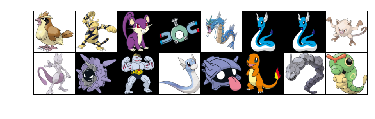

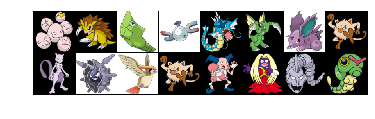

tensor([-11.8399,  -7.2781,  -3.4569,  -3.0672,  -5.3312,  -5.4766,   0.8715,
         -9.4494,   1.1545,   0.7813,  -8.7024, -14.3145, -12.6897,  -3.5146,
          1.2361,  -0.7348], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1]])


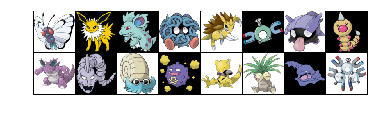

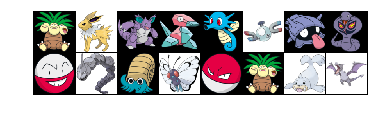

tensor([-14.0442,  -9.0646,  -3.6991, -18.2727,  -9.5694,  -3.0672,   1.6683,
         -8.8466, -11.5784,   1.2361,  -2.3565,  -8.8197,  -9.2910, -11.1426,
          1.6253,  -6.7794], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0]])


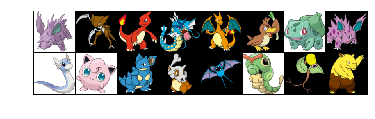

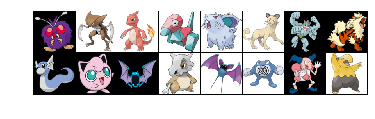

tensor([-14.7374,   2.0254,  -1.7532, -11.2388, -15.6031,  -6.6508,  -5.5535,
        -11.3053,  -2.3252,  -4.0885,  -8.1963,   0.2628,   3.8062,  -8.9297,
        -19.2710, -10.7342], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1]])


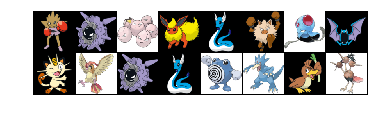

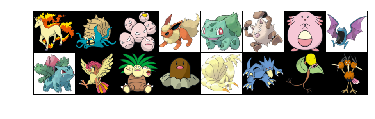

tensor([ -3.2849,  -9.5018,  -1.6733,  -3.7420,  -7.4054,  -5.5026, -15.4522,
          2.0020, -12.8478,  -2.7778, -17.2315, -12.2833, -13.5921,  -8.0495,
        -19.4892,  -2.7951], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1]])


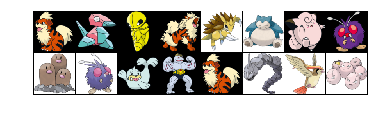

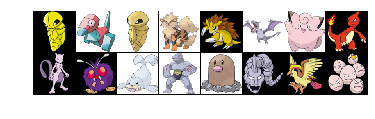

tensor([ -4.2424,  -9.1782,   1.7233,  -3.9772, -10.2543,  -6.5723,   3.8554,
         -2.0083,  -3.6557,  -4.0706, -12.0245,  -4.9525, -11.1358,   1.2361,
         -5.2175,  -1.6733], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1]])


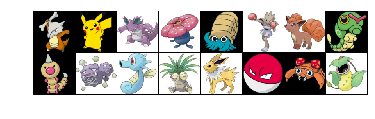

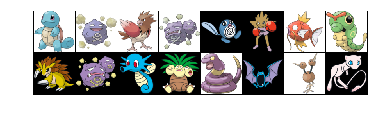

tensor([ -4.2606, -19.9338, -12.9645, -12.0043, -12.1448, -11.8736,  -5.8630,
         -0.7348,  -1.8629,  -5.5102,  -1.0724, -11.1426,  -6.9439,  -9.4723,
         -8.7212, -10.5015], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]])


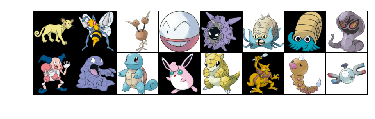

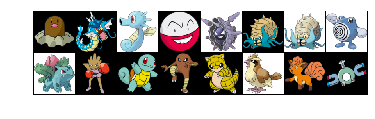

tensor([ -6.5643, -13.9842,  -4.6209,  -7.0331,   0.7813,  -7.5797,  -4.4707,
        -12.0967, -17.7513, -11.6002,  -1.5613,  -3.6637,  -4.3560,  -3.0200,
         -3.0888,  -3.0672], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1]])


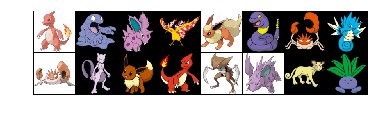

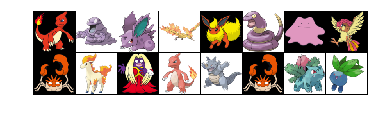

tensor([ -1.7532,  -0.8467,  -0.2125,   1.1247,  -3.7420,  -1.7880,  -7.5282,
        -16.0891,  -8.9957,  -8.4687,  -3.7225,  -1.7532,  -9.6454, -12.2577,
        -21.6573,  -0.5936], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1]])


In [17]:
def imshow(img):
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

for idx, (img_1, img_2, same) in enumerate(test_loader):
    imshow(torchvision.utils.make_grid(img_1))
    imshow(torchvision.utils.make_grid(img_2))
    
    data_1, data_2 = img_1.to(device), img_2.to(device)

    out = net(data_1, data_2)
    print(out)
    print(same)


In [18]:
results, labels = test_model(test_loader, net)
are_same = [elt[0] == 1 for elt in labels]
think_same = [elt > 0.5 for elt in results]
n_correct = 0
n_total = len(think_same)
for i in range(n_total):
    if think_same[i] == are_same[i]:
        n_correct += 1
print(f"Accuracy: %.1f%%" % (100 * n_correct/n_total))


Accuracy: 57.8%
